<a href="https://colab.research.google.com/github/Manan-Parakh/Neural-Machine-Translation/blob/main/NMT_Manan_Parakh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Bidirectional

In [2]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_path = "/content/drive/MyDrive/NMT/fra-eng/fra.txt"

In [4]:
batch_size = 64
epochs = 100
latent_dim = 256
num_samples = 10000

## Data Preprocessing

In [7]:
# Get the texts from the data

# Store the whole phrases
input_texts = []
target_texts = []

# Store the characters
input_characters = set()
target_characters = set()

with open(data_path, mode = 'r', encoding = 'utf-8') as f:
  lines = f.read().split('\n')

  for line in lines[:min(num_samples,len(lines)-1)]:
    # The english text ends with a tab
    input_text, target_text, _ = line.split('\t')

    # We use tab as the starting sequence of target sentence and \n as the end
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)

    # Get all the characters in use
    for character in input_text:
      if character not in input_characters:
        input_characters.add(character)
    for character in target_text:
      if character not in target_characters:
        target_characters.add(character)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))

num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)

max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 70
Number of unique output tokens: 91
Max sequence length for inputs: 14
Max sequence length for outputs: 59


In [10]:
# Map the input and target tokens to some index
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

In [17]:
# Initialize the encoder_input, decoder_input, decoder_target
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype = "float32"
)

decoder_input_data = np.zeros(
    (len(target_texts), max_decoder_seq_length, num_decoder_tokens), dtype = "float32"
)

decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

In [18]:
encoder_input_data.shape, decoder_input_data.shape, decoder_target_data.shape

((10000, 14, 70), (10000, 59, 91), (10000, 59, 91))

In [20]:
# One Hot Encode the input and target phrases character-wise
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
   # For encoder_input_data
   for t, character in enumerate(input_text):
    encoder_input_data[i,t, input_token_index[character]] = 1.0
    # End of sequence means blank space
   encoder_input_data[i,t+1:, input_token_index[" "]] = 1.0

   # For decoder_input_data
   for t, character in enumerate(target_text):
    decoder_input_data[i,t, target_token_index[character]] = 1.0
    # decoder_target_data is ahead of input by 1 timestep
    # i.e any input char has to predict the next char as the target
    # So the character at position j in input will be at j-1 in target
    if t>0:
      decoder_target_data[i,t-1,target_token_index[character]] = 1.0
    # End of sequence means blank space
   decoder_input_data[i,t+1:, target_token_index[" "]] = 1.0
   decoder_target_data[i,t:, target_token_index[" "]] = 1.0

## Showing the encoding

In [28]:
input_texts[0]

'Go.'

In [31]:
input_token_index["G"], input_token_index["o"], input_token_index["."],input_token_index[" "]

(26, 58, 9, 0)

In [30]:
encoder_input_data[0].argmax(axis=1)

array([26, 58,  9,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

# Construct the Model

In [33]:
# We have make an encoder and a decoder

# For Encoder, we need an input layer, encoder LSTM layer
# Each input phrase will be fed character-wise
encoder_inputs = keras.Input(shape = (None, num_encoder_tokens)) #num_encoder_tokens -> Unique characters in the input corpus
# Define the LSTM Layer with latenr_dim = 256 Neurons
encoder = keras.layers.LSTM(latent_dim, return_state = True)
# Feed the input into the encoder
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard the encoder_outputs and keep only the encoder states
encoder_states = [state_h, state_c]

# For Decoder, we need an input layer -> Inputs will be target_tokens while training
decoder_inputs = keras.Input(shape = (None,num_decoder_tokens))
# The decoder must return the full output sequences
# We do not use the decoder states while training but only during inference
# as we already have the target text while training
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences = True, return_state = True)
# Feed the decoder inputs into the LSTM
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state = encoder_states)

# Pass the decoder output through a softmax
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation = "softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# encoder_input_data & decoder_input_data into decoder_target_data

model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [35]:
# keras.Model automatically tracks the layers used to reach the decoder_outputs using the given inputs

In [36]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, 70)       │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None, 91)       │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 256), (None,   │        334,848 │ input_layer[0][0]      │
│                           │ 256), (None, 256)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, None, 256),    │        356,352 │ input_layer_1[0][0],   │
│                           │ (None, 256), (None,    │                │ lstm[0][1], lstm[0][2] │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, None, 91)       │         23,387 │ lstm_1[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 714,587 (2.73 MB)

 Trainable params: 714,587 (2.73 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

model.fit([encoder_input_data, decoder_input_data],
          decoder_target_data,
          epochs = epochs,
          batch_size = batch_size,
          validation_split = 0.2)

In [ ]:
# Save the Model
model.save("/content/drive/MyDrive/NMT/Models/fren_to_eng.keras")

# Inference Using the Model

In [44]:
model = keras.models.load_model("/content/drive/MyDrive/NMT/Models/fren_to_eng.keras")

In [45]:
model.layers

[<InputLayer name=input_layer, built=True>,
 <InputLayer name=input_layer_1, built=True>,
 <LSTM name=lstm, built=True>,
 <LSTM name=lstm_1, built=True>,
 <Dense name=dense, built=True>]

In [47]:
model.inputs # Tensors

[<KerasTensor shape=(None, None, 70), dtype=float32, sparse=False, name=input_layer>,
 <KerasTensor shape=(None, None, 91), dtype=float32, sparse=False, name=input_layer_1>]

In [49]:
model.layers[2].output

[<KerasTensor shape=(None, 256), dtype=float32, sparse=False, name=keras_tensor_22>,
 <KerasTensor shape=(None, 256), dtype=float32, sparse=False, name=keras_tensor_23>,
 <KerasTensor shape=(None, 256), dtype=float32, sparse=False, name=keras_tensor_24>]

In [101]:
# Separate the encoder from it
encoder_inputs = model.inputs[0] # Returns a tensor of the input shape
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output # Returns a tensor of the encoder output shape
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)
# We ignore the output of encoder. In Attention we will use them as well

# Decoder
# During inference, decoder inputs are -> 2 encoder states and decoder's previous timestep output as well
decoder_inputs = model.inputs[1]
decoder_state_input_h = keras.Input(shape = (latent_dim,), name = "input3")
decoder_state_input_c = keras.Input(shape = (latent_dim,), name = "input4")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Decoder LSTM
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h_dec, state_c_dec]

# Feed the decoder output to Dense layer
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = keras.Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [102]:
encoder_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, 70)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ [(None, 256), (None, 256),  │         334,848 │
│                                      │ (None, 256)]                │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 334,848 (1.28 MB)

 Trainable params: 334,848 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

In [103]:
decoder_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, None, 91)       │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input3 (InputLayer)       │ (None, 256)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input4 (InputLayer)       │ (None, 256)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, None, 256),    │        356,352 │ input_layer_1[0][0],   │
│                           │ (None, 256), (None,    │                │ input3[0][0],          │
│                           │ 256)]                  │                │ input4[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, None, 91)       │         23,387 │ lstm_1[2][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 379,739 (1.45 MB)

 Trainable params: 379,739 (1.45 MB)

 Non-trainable params: 0 (0.00 B)

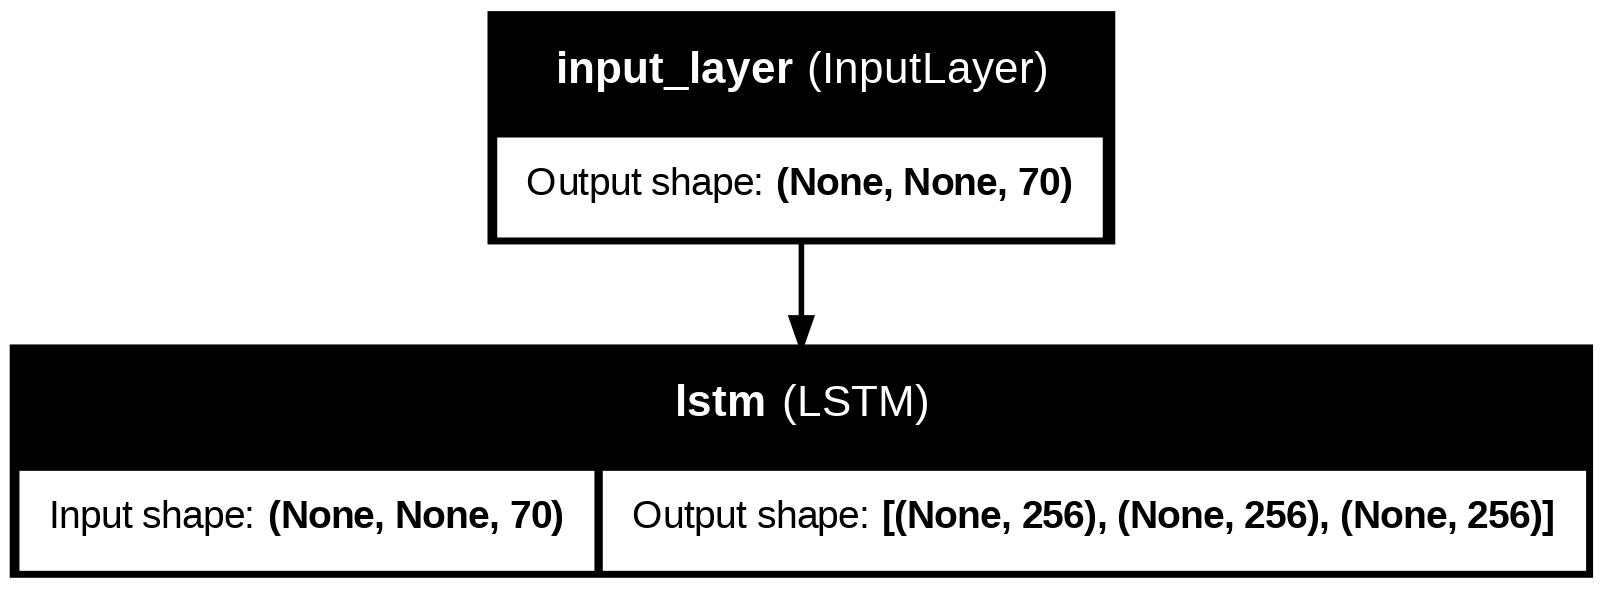

In [104]:
from tensorflow.keras.utils import plot_model

plot_model(encoder_model, show_shapes=True, show_layer_names=True)

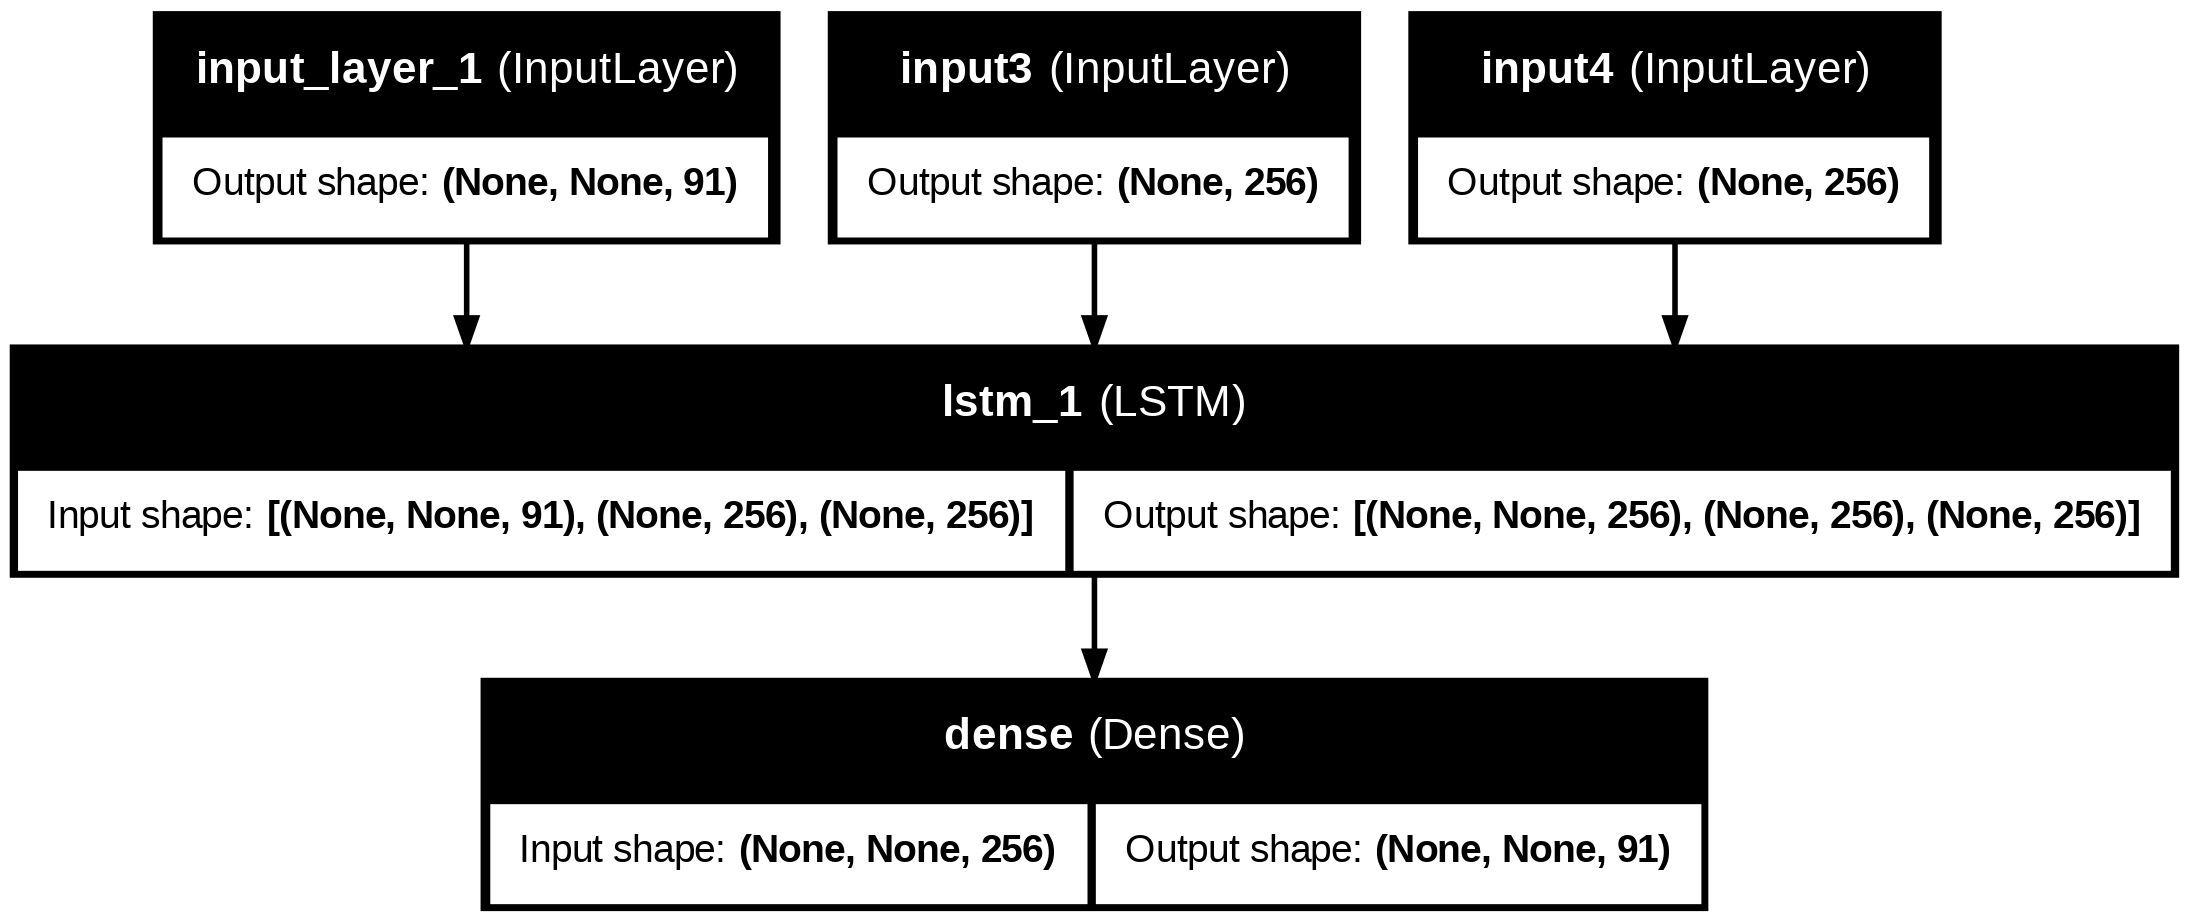

In [105]:
plot_model(decoder_model, show_shapes=True, show_layer_names=True)

In [57]:
input_token_index.items()

dict_items([(' ', 0), ('!', 1), ('"', 2), ('$', 3), ('%', 4), ('&', 5), ("'", 6), (',', 7), ('-', 8), ('.', 9), ('0', 10), ('1', 11), ('2', 12), ('3', 13), ('5', 14), ('7', 15), ('8', 16), ('9', 17), (':', 18), ('?', 19), ('A', 20), ('B', 21), ('C', 22), ('D', 23), ('E', 24), ('F', 25), ('G', 26), ('H', 27), ('I', 28), ('J', 29), ('K', 30), ('L', 31), ('M', 32), ('N', 33), ('O', 34), ('P', 35), ('Q', 36), ('R', 37), ('S', 38), ('T', 39), ('U', 40), ('V', 41), ('W', 42), ('Y', 43), ('a', 44), ('b', 45), ('c', 46), ('d', 47), ('e', 48), ('f', 49), ('g', 50), ('h', 51), ('i', 52), ('j', 53), ('k', 54), ('l', 55), ('m', 56), ('n', 57), ('o', 58), ('p', 59), ('q', 60), ('r', 61), ('s', 62), ('t', 63), ('u', 64), ('v', 65), ('w', 66), ('x', 67), ('y', 68), ('z', 69)])

In [58]:
# Reverse lookup table to convert the outputs of decoder into something readable
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [60]:
reverse_input_char_index # Mapping of numbers back to the characters

{0: ' ',
 1: '!',
 2: '"',
 3: '$',
 4: '%',
 5: '&',
 6: "'",
 7: ',',
 8: '-',
 9: '.',
 10: '0',
 11: '1',
 12: '2',
 13: '3',
 14: '5',
 15: '7',
 16: '8',
 17: '9',
 18: ':',
 19: '?',
 20: 'A',
 21: 'B',
 22: 'C',
 23: 'D',
 24: 'E',
 25: 'F',
 26: 'G',
 27: 'H',
 28: 'I',
 29: 'J',
 30: 'K',
 31: 'L',
 32: 'M',
 33: 'N',
 34: 'O',
 35: 'P',
 36: 'Q',
 37: 'R',
 38: 'S',
 39: 'T',
 40: 'U',
 41: 'V',
 42: 'W',
 43: 'Y',
 44: 'a',
 45: 'b',
 46: 'c',
 47: 'd',
 48: 'e',
 49: 'f',
 50: 'g',
 51: 'h',
 52: 'i',
 53: 'j',
 54: 'k',
 55: 'l',
 56: 'm',
 57: 'n',
 58: 'o',
 59: 'p',
 60: 'q',
 61: 'r',
 62: 's',
 63: 't',
 64: 'u',
 65: 'v',
 66: 'w',
 67: 'x',
 68: 'y',
 69: 'z'}

In [107]:
def decode_sequence(input_sentence):
    # Initialize an empty sequence (one-hot encoded)
    input_seq = np.zeros((1, max_encoder_seq_length, num_encoder_tokens), dtype="float32")

    # One-hot encode the input sentence
    for t, character in enumerate(input_sentence):
        if character in input_token_index:  # Check to avoid KeyError
            input_seq[0, t, input_token_index[character]] = 1.0

    # End-of-sequence padding (only if within bounds)
    if t + 1 < max_encoder_seq_length:
        input_seq[0, t+1:, input_token_index[" "]] = 1.0

    # Print for debugging (optional)
    print(f"Input sequence shape: {input_seq.shape} (should be (1, max_encoder_seq_length, {num_encoder_tokens}))")

    # Encode input sequence → Get initial decoder states
    states_value = encoder_model.predict(input_seq)

    # Create empty target sequence for decoding
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index["\t"]] = 1.0  # Start token

    # Start decoding loop
    stop_condition = False
    decoded_sentence = ""

    while not stop_condition:
        # Predict next token
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Get most likely next character
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Stop condition: End token or max length reached
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True
        else:
            # Update target sequence (instead of recreating array)
            target_seq.fill(0)
            target_seq[0, 0, sampled_token_index] = 1.0

            # Update decoder states
            states_value = [h, c]

    return decoded_sentence

In [115]:
decode_sequence("Hello!")

Input sequence shape: (1, 14, 70) (should be (1, max_encoder_seq_length, 70))
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


'Salut !\n'

In [120]:
for i in range(10):
  print(input_texts[i])
  print(decode_sequence(input_texts[i]))

Go.
Input sequence shape: (1, 14, 70) (should be (1, max_encoder_seq_length, 70))
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
En route !

Go.
Input sequence shape: (1, 14, 70) (should be (1, max_encoder_seq_length, 70))
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0